# Azure AI Search text splitter data chunking example

This notebook uses the Text Split skill in Azure AI Search to chunk text. This approach takes a dependency on indexers and skillsets.

The notebook complements the [Chunking large documents for vector search solutions](https://learn.microsoft.com/azure/search/vector-search-how-to-chunk-documents) article in the Azure AI Search documentation.

## Prerequisites

* An Azure subscription.
* An Azure Storage account with blob storage.
* Azure AI Search, Standard (S1) or higher to accommodate the large PDF.
* Azure OpenAI with a text embedding model, either text-embedding-ada-002 or a text-embedding-3 model.

You can use keys for authenticated connections, or you can set up managed identities and role assignments for service-to-service communication. For role-based access, an Azure AI Search service needs **Cognitive Services OpenAI User** on Azure OpenAI and **Storage Blob Data Reader** on Azure Storage.

### Set up a Python virtual environment in Visual Studio Code

1. Open the Command Palette (Ctrl+Shift+P).
1. Search for **Python: Create Environment**.
1. Select **Venv**.
1. Select a Python interpreter. Choose 3.10 or later.

It can take a minute to set up. If you run into problems, see [Python environments in VS Code](https://code.visualstudio.com/docs/python/environments).

### Install packages

In [1]:
%pip install --quiet -r requirements.txt

Note: you may need to restart the kernel to use updated packages.


### Load .env file (Copy .env-sample to .env and update accordingly)

In [2]:
from dotenv import load_dotenv
from azure.identity import DefaultAzureCredential
from azure.core.credentials import AzureKeyCredential
import os

load_dotenv() # take environment variables from .env.

search_endpoint = os.environ["AZURE_SEARCH_SERVICE_ENDPOINT"]
search_index = os.environ["AZURE_SEARCH_INDEX"]
search_datasource = os.environ["AZURE_SEARCH_DATASOURCE"]
search_skillset = os.environ["AZURE_SEARCH_SKILLSET"]
search_indexer = os.environ["AZURE_SEARCH_INDEXER"]
azure_openai_endpoint = os.environ["AZURE_OPENAI_ENDPOINT"]
azure_openai_embedding_deployment_id = os.environ["AZURE_OPENAI_EMBEDDING_DEPLOYMENT_ID"]
blob_container = os.environ["AZURE_BLOB_CONTAINER"]
blob_connection_string = os.environ["AZURE_BLOB_CONNECTION_STRING"]
blob_account_url = os.environ["AZURE_BLOB_ACCOUNT_URL"]

search_credential = AzureKeyCredential(os.environ["AZURE_SEARCH_ADMIN_KEY"]) if len(os.environ["AZURE_SEARCH_ADMIN_KEY"]) > 0 else DefaultAzureCredential()
azure_openai_key = os.environ["AZURE_OPENAI_KEY"] if len(os.environ["AZURE_OPENAI_KEY"]) > 0 else None

### Upload sample PDF for chunking

This step creates a blob container on Azure Storage and loads a single large PDF into the container.

In [3]:
from azure.storage.blob import BlobServiceClient

def open_blob_client():
    # Set max_block_size and max_single_put_size due to large PDF transfers
    # See https://learn.microsoft.com/azure/storage/blobs/storage-blobs-tune-upload-download-python
    if not blob_connection_string.startswith("ResourceId"):
        return BlobServiceClient.from_connection_string(
            blob_connection_string,
            max_block_size=1024*1024*8, # 8 MiB
            max_single_put_size=1024*1024*8 # 8 MiB
        )
    return BlobServiceClient(
        account_url=blob_account_url,
        credential=DefaultAzureCredential(),
        max_block_size=1024*1024*8, # 8 MiB
        max_single_put_size=1024*1024*8 # 8 MiB
    )

blob_client = open_blob_client()
container_client = blob_client.get_container_client(blob_container)
if not container_client.exists():
    container_client.create_container()

file_path = os.path.join("..", "..", "..", "data", "nasa-ebooks", "earth_at_night_508.pdf")
blob_name = os.path.basename(file_path)
blob_client = container_client.get_blob_client(blob_name)
if not blob_client.exists():
    with open(file_path, "rb") as f:
        blob_client.upload_blob(data=f, overwrite=True)

### Create the index and run the indexer

This step creates an index, data source, skillset, and indexer on Azure AI Search. The skillset includes a text split skill that chunks the data and calls the embedding model on Azure OpenAI. Vector and non-vector chunks are indexed in Azure AI Search.

In [4]:
from azure.search.documents.indexes import SearchIndexClient, SearchIndexerClient
from lib.common import (
    create_search_index,
    create_search_datasource,
    create_search_skillset,
    create_search_indexer
)

search_index_client = SearchIndexClient(endpoint=search_endpoint, credential=search_credential)
index = create_search_index(
    search_index,
    azure_openai_endpoint,
    azure_openai_embedding_deployment_id,
    azure_openai_key
)
search_index_client.create_or_update_index(index)

search_indexer_client = SearchIndexerClient(endpoint=search_endpoint, credential=search_credential)

data_source = create_search_datasource(
    search_datasource,
    blob_connection_string,
    blob_container
)
search_indexer_client.create_or_update_data_source_connection(data_source)

skillset = create_search_skillset(
    search_skillset,
    search_index,
    azure_openai_endpoint,
    azure_openai_embedding_deployment_id,
    azure_openai_key,
    text_split_mode='pages',
    maximum_page_length=2000,
    page_overlap_length=500
)
search_indexer_client.create_or_update_skillset(skillset)

indexer = create_search_indexer(
    indexer_name=search_indexer,
    index_name=search_index,
    datasource_name=search_datasource,
    skillset_name=search_skillset
)
search_indexer_client.create_or_update_indexer(indexer)
search_indexer_client.run_indexer(search_indexer)

print("Running indexer")


vectorizer is not a known attribute of class <class 'azure.search.documents.indexes._generated.models._models_py3.VectorSearchProfile'> and will be ignored
name is not a known attribute of class <class 'azure.search.documents.indexes._generated.models._models_py3.AzureOpenAIVectorizer'> and will be ignored


Running indexer


### Show chunk character length and token length histogram

If you get an error, check the Azure portal to make sure the index exists and the indexer ran successfully. Also, if you use role-based access, make sure you have individual permissions to read an index. For more information, see [Quickstart: Connect without keys](https://learn.microsoft.com/azure/search/search-get-started-rbac).

Error processing result: list index out of range


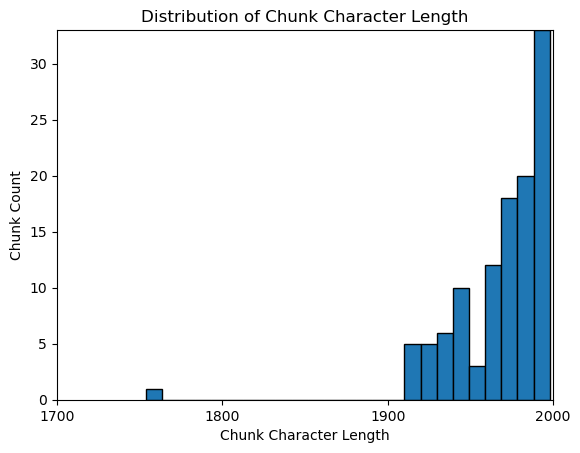

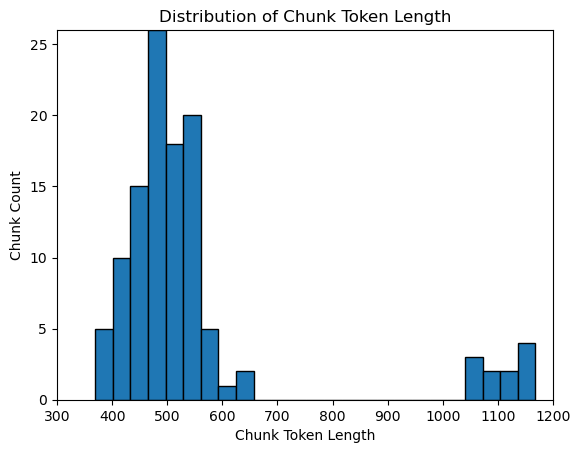

In [5]:
%matplotlib inline
from lib.common import (
    get_chunks,
    get_token_length,
    plot_chunk_histogram
)

search_client = search_index_client.get_search_client(search_index)
chunks = get_chunks(search_client)

plot_chunk_histogram(chunks, length_fn=len, title="Distribution of Chunk Character Length", xlabel="Chunk Character Length")
plot_chunk_histogram(chunks, length_fn=get_token_length, title="Distribution of Chunk Token Length", xlabel="Chunk Token Length")